## Import Our Librairies
```python
import pyodbc
```
Is the python sql driver to get our data from the sql server

In [2]:
import pandas as pd
import pyodbc
import numpy as np
import seaborn as sns
%matplotlib inline

## Create sql connexion

In [3]:
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=localhost;DATABASE=DW_ANAP_Test')

## Table from database to dataframe
Load ** ActiviteFait ** table wich contains our indicators .

** Fk_Date ** : ** Year ** : 1->2008 2->2009 3->2010 4->2011 5->2012 6->2013 7->2014 8->2015

** Fk_Hopt ** : Represent a hospital we don't need hospitals name

PS:Each Hospital can have from 2 to 8 years of each indicator(database has some NA columun we change them to zero because they don't effect us is this case)

In [4]:
ActFact= pd.read_sql("SELECT * FROM ActiviteFait",cnxn)
ActFact.head()

,Fk_Hopt,Fk_Date,A1_bis,A2_bis,A3_bis,A4_bis,A5_bis,A13,A14,A15
0,1346,1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
1,1347,1,0.0,0.0,0.0,0.0,0.0,67.2,0.0,0.0
2,1348,1,0.0,0.6,0.4,1.0,0.5,87.7,79.4,56.2
3,1349,1,0.0,1.9,1.2,2.6,0.7,79.9,78.4,61.4
4,1350,1,0.0,0.6,0.5,0.6,0.2,71.8,74.0,65.1


## Description to our ActFact Dataframe
** Indicators **  : From A1_bis to A15 .

There are many indicators that concern frensh medical institution in this database, check this link (Sorry because it's in French)
https://www.data.gouv.fr/s/resources/hospi-diag/20150817-171102/Hospi-Diag_Presentation_et_Principes_utilisation_aout_2015.pdf

But as mentioned in the README I choosed the activity axis and precisely A15 "Bed Use / Occupancy Rate in Obstetrics"

In [6]:
ActFact.loc[:,'A1_bis':'A15'].describe()

,A1_bis,A2_bis,A3_bis,A4_bis,A5_bis,A13,A14,A15
count,10778.000000,10778.000000,10778.000000,10778.00000,10778.000000,10778.000000,10778.000000,10778.000000
mean,0.887140,1.314511,1.358824,1.35219,1.134301,56.827937,39.430683,20.757821
std,3.232933,3.631954,3.936344,3.59508,3.260610,62.401468,81.477073,35.104714
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.200000,0.500000,0.000000,0.40000,0.300000,71.200000,39.700000,0.000000
75%,0.800000,1.300000,1.500000,1.40000,1.000000,84.300000,69.175000,50.700000
max,78.100000,78.900000,78.200000,79.10000,76.600000,1674.000000,5748.400000,1840.800000


## Seaborn pairplot to detect any clusters
** We could have used some clustering method ** such as k-means but this is not the purpose of this notebook and we will see later that with the partition I got some pretty good result

I needed to divide my data into Blocks to define my states for the markov chain, you see that we have 3 clusters of points when you analyse the seaborn pairplot graphe.

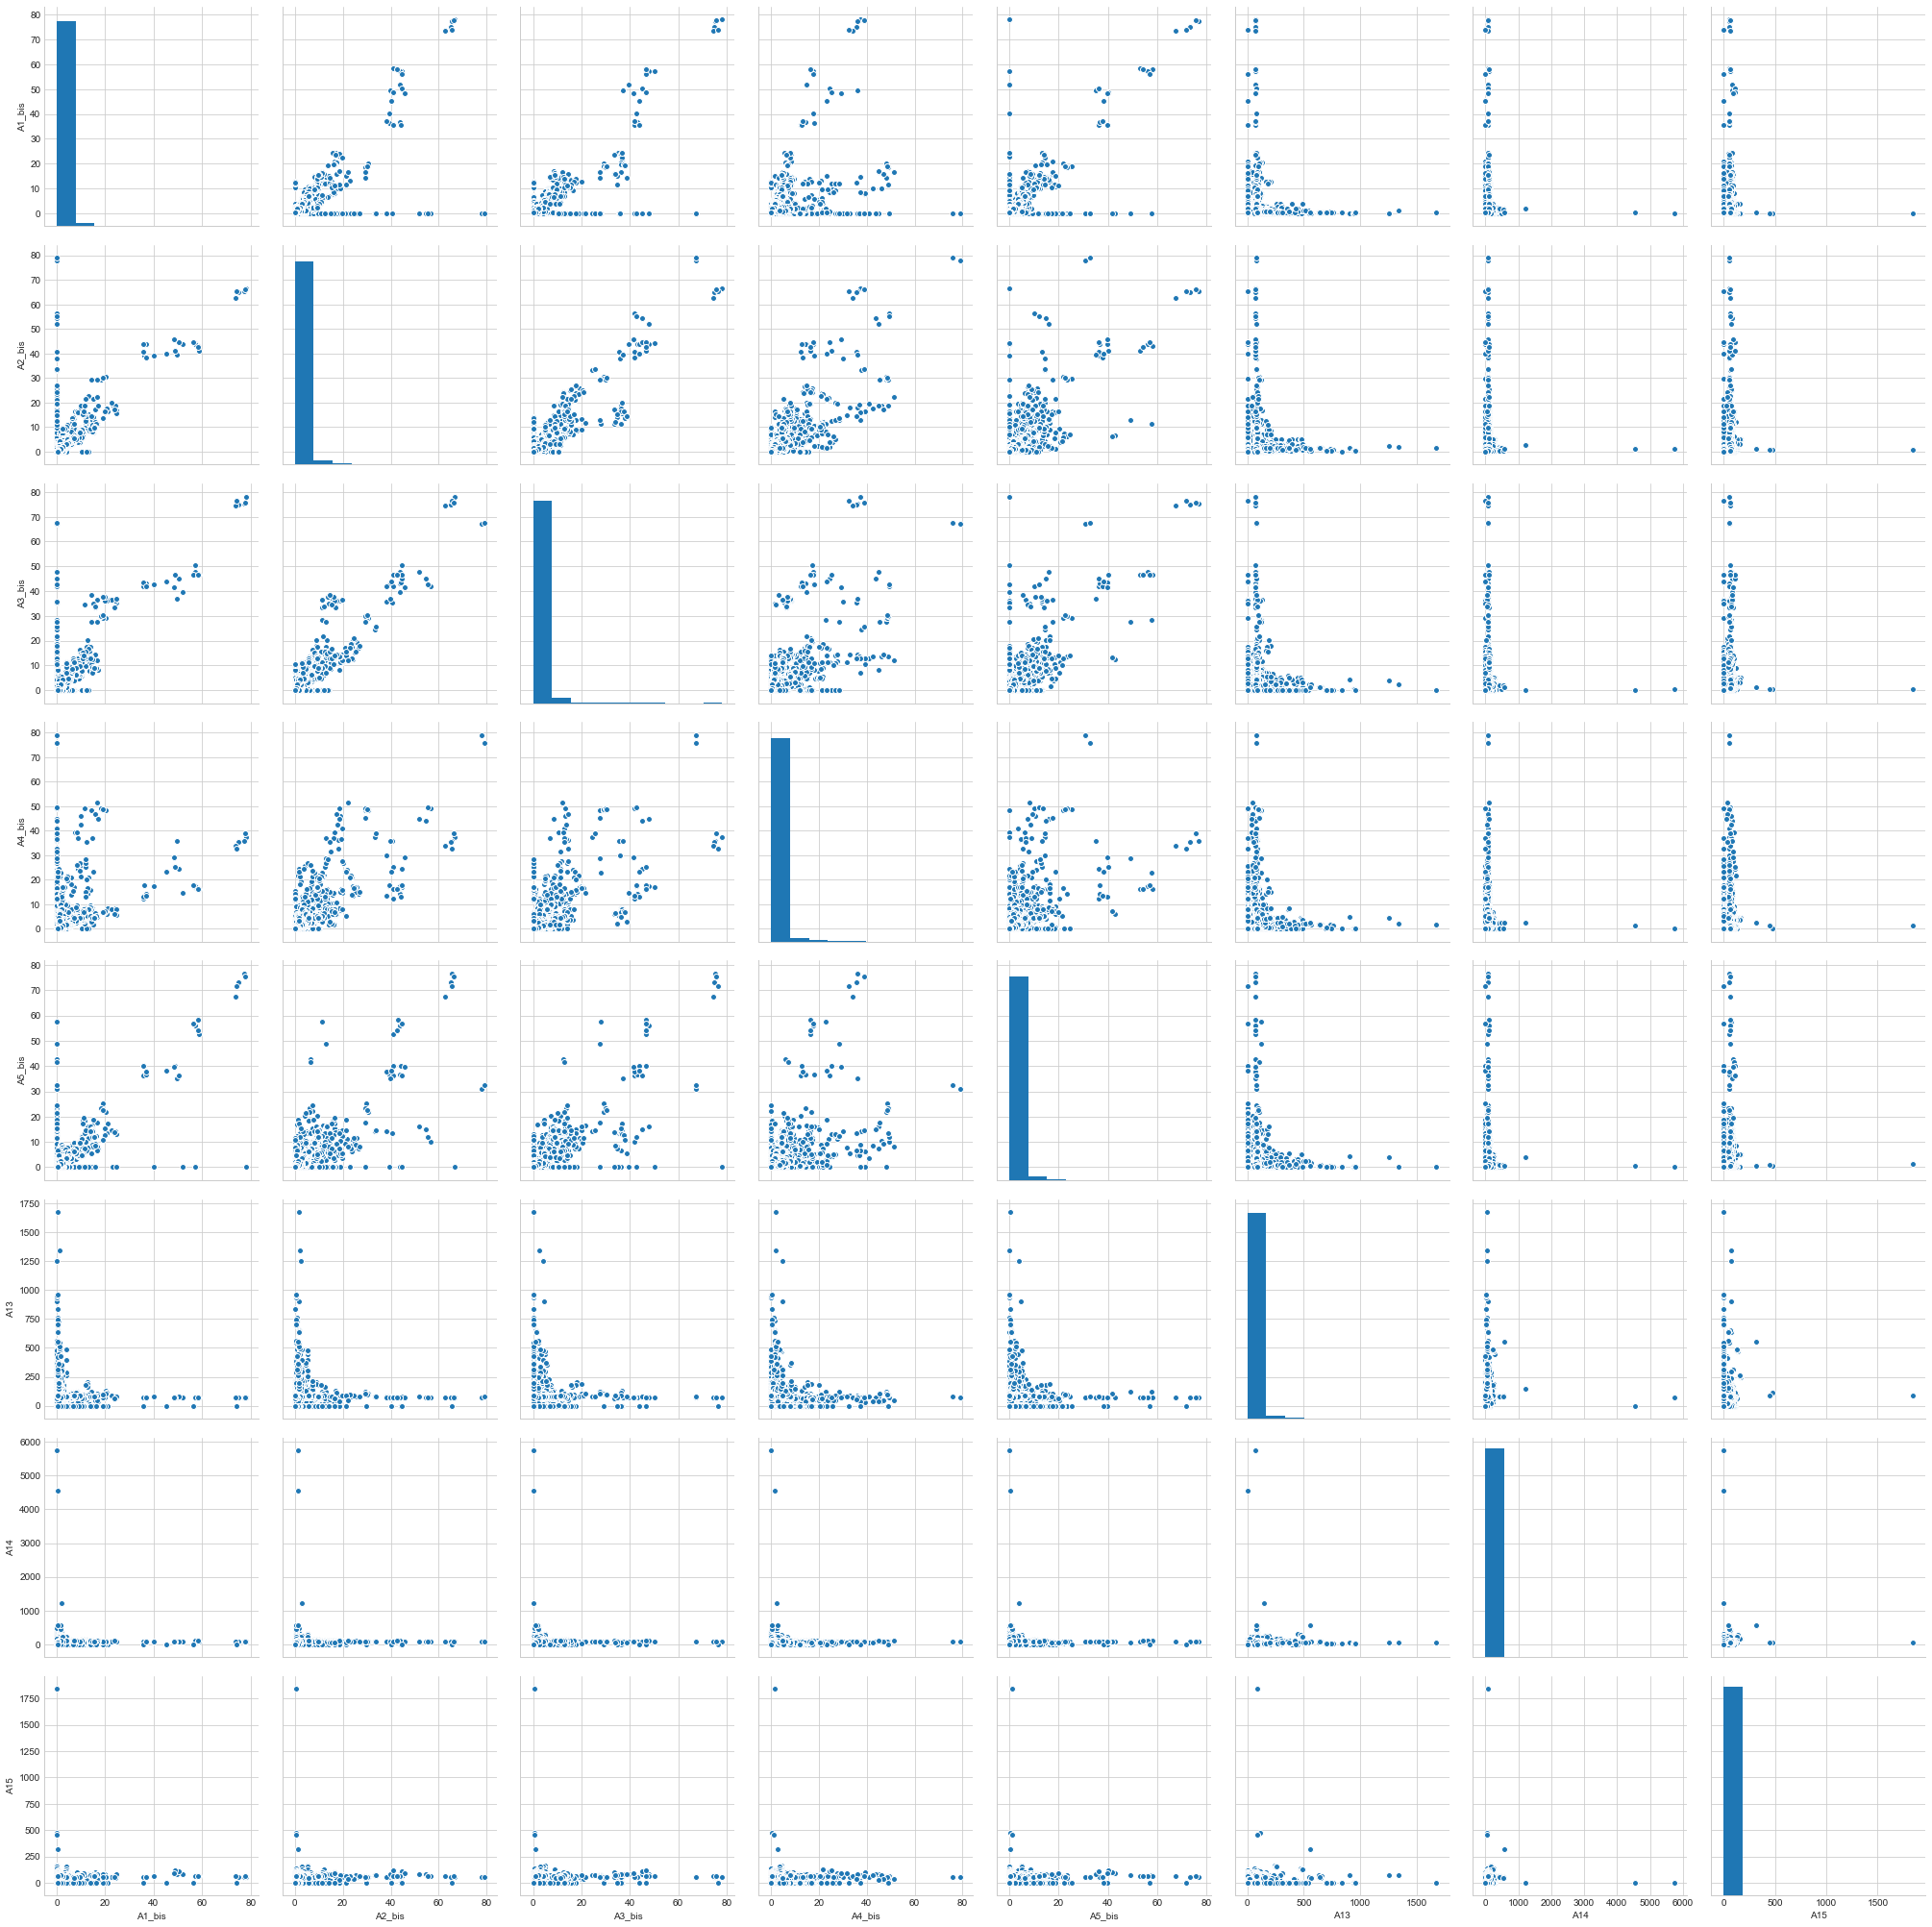

In [8]:
import seaborn as sns
sns.set_style("whitegrid")
sns.pairplot(ActFact.loc[:,'A1_bis':'A15'], size=3.5)


** We have then 3 States ** 

** A ** under 30 ,
** B ** between 30 and 60 ,
** C ** over 60

Then We transform our quantitative variables to categorical variables.

The markov chain States needs to be discrete that's why we need this transformation .

In [13]:
ActFactUp = ActFact.loc[:,'A1_bis':'A15']

def func(column):
    if column < 30:
        return 'A'
    elif column > 30 and column <60:
        return 'B' 
    else:
        return 'C'

for column in ActFactUp:
    #ActFactUp[column] = ActFactUp[column].apply(lambda column:"A" if column < 30 else (column : "B" if (column > 30 and column <60) else column:"C"))  
    ActFactUp[column]=ActFactUp[column].apply(func)
    


** Final result after transformation **

In [14]:
ActFactUp['Fk_Hopt'] = ActFact['Fk_Hopt']
ActFactUp['Fk_Date'] = ActFact['Fk_Date']
ActFactUp.reset_index(inplace=True)
ActFactUp.drop('index', inplace=True, axis=1)
ActFactUp.head()

,A1_bis,A2_bis,A3_bis,A4_bis,A5_bis,A13,A14,A15,Fk_Hopt,Fk_Date
0,A,A,A,A,A,A,A,A,1346,1
1,A,A,A,A,A,C,A,A,1347,1
2,A,A,A,A,A,C,C,B,1348,1
3,A,A,A,A,A,C,C,C,1349,1
4,A,A,A,A,A,C,C,C,1350,1


## So Now let's Define What's a markov chain
Very Simple : A Markov chain is a stochastic process, but it differs from a general stochastic process in that a Markov chain must be "memory-less". That is, (the probability of) ** future ** actions are not dependent upon the steps that led up to the ** present  ** state.

So the general proprety of a markov chain is  :
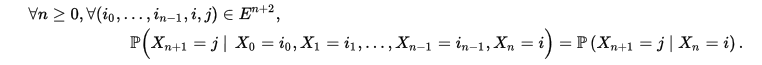

Now to the implementation ,first we need to define a dictionary we call it ** MarkovList ** to append each hospital as ** key ** and  "A15" indicator from the year 2008 to 2014 (we keep 2015 for the test) as ** value ** represented in an array respectively to each hospital our goal is to see how the indicator evolve in time from ** A ** : Bad activity to ** B ** : good activity and finaly ** C ** very good activity  .

```python
for row in ActFactUp.itertuples(): # iterate over dataframe on each step it returns a row

if row[9] not in MarkovList: # row[9] : Fk_Hopt
        MarkovList[row[9]] = []# if hospital key don't existe create key in the dectionary
        
```
```python
for row in ActFactUp.itertuples():
    MarkovList[row[9]].append(row[7]) # append row[7] : A15 to the array for each hospital row[9] : Fk_hopt
```

In [15]:
MarkovList = {}
for row in ActFactUp.itertuples():
    if row[9] not in MarkovList:
        MarkovList[row[9]] = []

for row in ActFactUp.itertuples():
    MarkovList[row[9]].append(row[7])
print(MarkovList)

{1346: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], 1347: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], 1348: ['C', 'C', 'C', 'C', 'A', 'C', 'C', 'C'], 1349: ['C', 'C', 'C', 'C', 'C', 'C', 'A', 'C'], 1350: ['C', 'C', 'C', 'B', 'A', 'C', 'C', 'C'], 1351: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], 1352: ['B', 'B', 'B', 'B', 'A', 'B', 'C', 'B'], 1353: ['B', 'B', 'B', 'B', 'C', 'B', 'A', 'B'], 1354: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], 1355: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], 1356: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], 1357: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], 1358: ['C', 'C', 'C', 'C', 'A', 'C', 'C', 'C'], 1359: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], 1360: ['C', 'C', 'C', 'C', 'A', 'C', 'C', 'C'], 1361: ['C', 'C', 'C', 'C', 'C', 'C', 'A', 'C'], 1362: ['B', 'B', 'B', 'B', 'A', 'C', 'C', 'C'], 1363: ['A', 'A'], 1364: ['B', 'C', 'B', 'A', 'B', 'B', 'B', 'B'], 1365: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'A'], 1366: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A'], 1367: ['C', 'C', 'B',

In [16]:
len(MarkovList)

1418

## Now let's build our Transition matrix
Is a square matrix used to describe the transitions of a Markov chain Each of its entries is a nonnegative real number representing a probability .

Example :
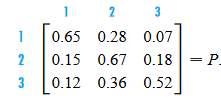  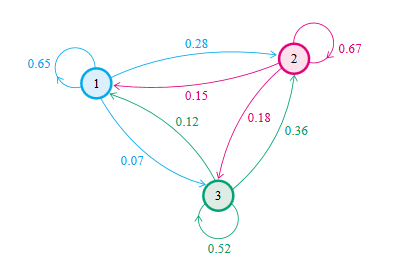

In [17]:
A_A = 0 
A_B = 0
A_C = 0
B_A = 0 
B_B = 0
B_C = 0
C_A = 0
C_B = 0
C_C = 0

for key,value in MarkovList.items():
    
    for i in range(len(value)-2): #on prend pas 2015
        if value[i] == "A":
            if value[i+1] == "A":
                A_A = A_A + 1
            elif value[i+1] == "B":
                A_B = A_B + 1
            else:
                A_C = A_C + 1
        elif value[i] == "B":
            if value[i+1] == "A":
                B_A = B_A + 1
            elif value[i+1] == "B":
                B_B = B_B + 1
            else:
                B_C = B_C + 1
        else:
            if value[i+1] == "A":
                C_A = C_A + 1
            elif value[i+1] == "B":
                C_B = C_B + 1
            else:
                C_C = C_C + 1
        
                                    #   A   B   C 
Matrice = np.array([ [A_A,A_B,A_C], #A A-A A-B A-C
                    [B_A,B_B,B_C],  #B B-A B-B B-C
                    [C_A,C_B,C_C]]) #C C-A C-B C-C
print(Matrice)
    

[[2885  251  325]
 [ 368 1188  196]
 [ 482  200 2047]]


Here we added each transition to the corresponding variable for example when ** A **  finds after it  ** A ** we add 1 to ** A_A **  when ** A **  finds after it  ** B **  we add 1 to ** A_B **  when ** C ** finds after it ** B ** we add to  ** C_B ** 1 ,ext.. until we finish all the dictionary .
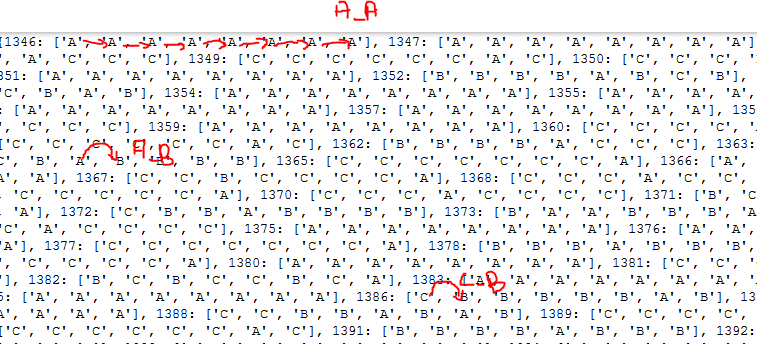

## Transition matrix

In [19]:
Matrice = Matrice/sum(sum(Matrice))
print(Matrice)

[[ 0.36325863  0.03160413  0.04092168]
 [ 0.04633594  0.14958449  0.02467892]
 [ 0.06069     0.02518257  0.25774364]]


In [20]:
Matrice[0] # transition from B

array([ 0.36325863,  0.03160413,  0.04092168])

** Normalize the matrix so that the sum  equals 1 **

In [22]:
State = ["A","B","C"]
probsA = np.squeeze(np.asarray(Matrice[0]))
probsB = np.squeeze(np.asarray(Matrice[1]))
probsC = np.squeeze(np.asarray(Matrice[2]))
probsA /= probsA.sum()
probsB /= probsB.sum()
probsC /= probsC.sum()
print("A source ",probsA)
print("B source ",probsB)
print("C source ",probsC)
np.random.choice(State,1,p=probsA)

A source  [ 0.83357411  0.07252239  0.0939035 ]
B source  [ 0.21004566  0.67808219  0.11187215]
C source  [ 0.17662147  0.07328692  0.75009161]


array(['A'],
      dtype='<U1')

## Time To test on 2015 result
to test our transition matrice we can use a markov chain propritie which is :
\begin{equation*}
U_{n+1}  =  P * U_{n}
\end{equation*}

With U is the probabilty at an initial state 
\begin{equation*}
U_{n}  =  P(X_{n})
\end{equation*}

For us we use 2015 and 2014 to test and to see if our transition matrix predict very close result
\begin{equation*}
U_{2015}  =  P * U_{2014}
\end{equation*}

In [25]:
possbilite_A2014 = []
possbilite_A2015 = []
for key,value in MarkovList.items():
    if len(value) == 8:
        possbilite_A2014.append(value[6])
        possbilite_A2015.append(value[7])
#U1 p = U2
a11 = 0
a12 = 0
a13 = 0
a21 = 0
a22 = 0
a23 = 0 
for a1 in possbilite_A2014:
        if a1 == "A":
            a11 = a11 + 1
        elif a1 == "B":
            a12 = a12 + 1
        else:
            a13 = a13 + 1
for a2 in possbilite_A2015:
        if a2 == "A":
            a21 = a21 + 1
        elif a2 == "B":
            a22 = a22 + 1
        else:
            a23 = a23 + 1
U2014 = np.array([a11,a12,a13])/len(possbilite_A2014)
U2015 = np.array([a21,a22,a23])/len(possbilite_A2015)
print("predict : U2014 * P : ",np.dot(Matrice,U2014))
print("U2015 :",U2015)


predict : U2014 * P :  [ 0.49943031  0.26193538  0.31841773]
U2015 : [ 0.45073701  0.21411947  0.33514352]


## Yes it did

You can see that the test result are significant we didn't show the data from 2015 to the chain but it did predict that in the year 2015 49.99% of hospital activity will have the rate ** A ** wich means bad and for the real data we have 45% the same for ** B ** and ** C ** we have 26% ** B ** predicted for 21.5% in the real data and for ** C ** from 31.8% predicted compared to 33.5% 

it's pretty close Right :p
Now we can even forecast for years to come to see how the activity of hospitals will evolve,and we can see that from 2016 to 2020 ** A ** will decrease which mean less hospitals will have bad activity and ** B ** will increase significantly, which is logical due to the decrease of ** A ** that means more hospitals will have a good activity and finally for ** C ** we can say that it will be stable

In [26]:
U2016 = np.dot(Matrice,U2015)
print("U2016 :",U2016)
U2017 = np.dot(Matrice,U2016)
print("U2017 :",U2017)
U2018 = np.dot(Matrice,U2017)
print("U2018 :",U2018)
U2019 = np.dot(Matrice,U2018)
print("U2019 :",U2019)
U2020 = np.dot(Matrice,U2019)
print("U2020 :",U2020)

U2016 : [ 0.4227223   0.27735918  0.34669033]
U2017 : [ 0.40504055  0.3156483   0.35503815]
U2018 : [ 0.39386221  0.33883138  0.36098288]
U2019 : [ 0.38678376  0.3528685   0.36516666]
U2020 : [ 0.38229422  0.36136808  0.36808341]


## Finally 
This algorithm can be applied to different indicators in this big database, if you have any questions don't hesitate to contact me.

Good Read.